# Hippocampus

## Pattern separation

Define DG block

In [229]:
import torch
import torch.nn as nn
import torch.optim as optim

class DGModel(nn.Module):
    """
    Goal: separation
    Methods: sparsity
    """
    
    def __init__(self, input_size, output_size):
        super(DGModel, self).__init__()
        hidden_layer_size = input_size + output_size // 2
        # self.fc1 = nn.Linear(input_size, hidden_layer_size)
        # self.fc2 = nn.Linear(hidden_layer_size, output_size)
        self.fc1 = nn.Linear(input_size, output_size)
        
        # Weight initialization (Xavier)
        nn.init.xavier_uniform_(self.fc1.weight)
        # nn.init.xavier_uniform_(self.fc2.weight)
        self.k = 5  # Number of top activations to keep
        
    def forward(self, x):
        with torch.no_grad():  # Ensure no gradients are calculated for this model
            x = self.fc1(x)
            x = torch.tanh(x)  # Using tanh activation
            # x = self.fc2(x)
            # x = torch.relu(x)
            # Top-k sparsity: keep only top-k values, set others to zero
            mask_pos = torch.zeros_like(x)
            mask_neg = torch.zeros_like(x)
            _, topk_pos_indices = torch.topk(x, self.k, largest=True)
            _, topk_neg_indices = torch.topk(x, self.k, largest=False)
            mask_pos.scatter_(0, topk_pos_indices, 1)
            mask_neg.scatter_(0, topk_neg_indices, 1)
            x = x * (mask_pos + mask_neg)
        return x


We need some data to test these blocks

In [230]:
import math

w = 5
h = 5
sk = 5
w_s = w * sk
h_s = h * sk

# dg_model - Sparse encoding
N = w * h  # Input size
M = w_s * h_s   # Output size

# ec_to_ca3_model - Correcting encoding
H = N  # Input size
L = M   # Output size ?? M ??

# ca3_memory_model
T = M # or L # Input size
K = T # Output size = Input size

# ca1_model
input_size = N + K # the original input pattern + memory
hidden_size = math.floor(input_size * 0.7)  # Size of hidden layer
output_size = N  # Same as input size for reconstruction

def to_uni_binary(t):
    """from [0, 1] to [-1, 1]"""
    return t * 2.0 - 1.0

# super simple ARC-like example
input_1 = to_uni_binary(torch.tensor([[[[0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0]]]], dtype=torch.float))

output_1 = to_uni_binary(torch.tensor([[[[0, 0, 1, 0, 0],
                           [0, 0, 1, 0, 0],
                           [1, 1, 1, 1, 1],
                           [0, 0, 1, 0, 0],
                           [0, 0, 1, 0, 0]]]], dtype=torch.float))

input_2 = to_uni_binary(torch.tensor([[[[0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1]]]], dtype=torch.float))

output_2 = to_uni_binary(torch.tensor([[[[0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [1, 1, 1, 1, 1]]]], dtype=torch.float))

We are going to work with 1D arrays. 

DG block creates a sparse representation of the input

In [231]:
dg_model = DGModel(N, M)

def forward_dg_model(dg_model, x):
    return dg_model(x.flatten())


In [232]:
x = input_1.flatten()
xx = input_2.flatten()

y = forward_dg_model(dg_model, x)
yy = forward_dg_model(dg_model, xx)

print(y)
print(y.shape)

tensor([ 0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,
         0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
        -0.0000,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,
        -0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,
         0.0000,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,
         0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,
         0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000,
        -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
         0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000,
         0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,
        -0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
         0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,
         0.0000,  0.0000, -0.0000,  0.00

Before the sparse representation hits the memory
we need to add one independent network between the same input and the memory in parallel.
This will be used later as part of retrieval.
Its gould would be to help balance between sparse representation and real input and select important regions 
(that would help with ignoring noise (or with detecting invariants))

We add an Encoding model

In [233]:
class EncodingModel(nn.Module):
    """
    Goal: pattern retrieval
    Methods: compare sparse representation with the original
    """
    
    def __init__(self, input_size, output_size):
        super(EncodingModel, self).__init__()
        hidden_layer_size = output_size
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        # x = torch.clamp(x * 10.0, min=-1.0, max=1.0)
        return x

In [234]:
ec_model = EncodingModel(H, L)
ec_optimizer = optim.AdamW(ec_model.parameters(), lr=0.0001)
ec_criterion = nn.MSELoss() # good for comparing pixel values

def forward_ec_to_ca3_model(ec_model, x):
    return ec_model(x)

def train_ec_to_ca3_model(ec_model, x, y):
    # Zero the parameter gradients
    ec_optimizer.zero_grad()

    # Compare reconstruction with the original input
    
    z = forward_ec_to_ca3_model(ec_model, x)
    loss = ec_criterion(z, y)

    # Backward pass: compute gradients
    loss.backward()

    # Optimization step: update weights
    ec_optimizer.step()

    print("Loss:", loss.item())
    # print("EC -> CA3 output:", z)
    
    return z, loss.item()


In [235]:
for i in range(500):
    print(i, "train_ec_to_ca3")
    z, loss1 = train_ec_to_ca3_model(ec_model, x, y)
    zz, loss2 = train_ec_to_ca3_model(ec_model, xx, yy)
    loss = (loss1 + loss2) / 2.0
    if loss < 0.0001:
        break

0 train_ec_to_ca3
Loss: 0.0765082985162735
Loss: 0.0716237723827362
1 train_ec_to_ca3
Loss: 0.05823006108403206
Loss: 0.05633070692420006
2 train_ec_to_ca3
Loss: 0.044794369488954544
Loss: 0.043834272772073746
3 train_ec_to_ca3
Loss: 0.03449191153049469
Loss: 0.033963244408369064
4 train_ec_to_ca3
Loss: 0.026725295931100845
Loss: 0.026353979483246803
5 train_ec_to_ca3
Loss: 0.020982775837183
Loss: 0.020591238513588905
6 train_ec_to_ca3
Loss: 0.0167990792542696
Loss: 0.016268029808998108
7 train_ec_to_ca3
Loss: 0.013768983073532581
Loss: 0.013025152496993542
8 train_ec_to_ca3
Loss: 0.011561097577214241
Loss: 0.01057656854391098
9 train_ec_to_ca3
Loss: 0.00992286391556263
Loss: 0.008710669353604317
10 train_ec_to_ca3
Loss: 0.008671964518725872
Loss: 0.0072729806415736675
11 train_ec_to_ca3
Loss: 0.007680566515773535
Loss: 0.006149792578071356
12 train_ec_to_ca3
Loss: 0.0068626729771494865
Loss: 0.005260041449218988
13 train_ec_to_ca3
Loss: 0.006164608523249626
Loss: 0.004548561293631792


Loss: 0.000823783571831882
35 train_ec_to_ca3
Loss: 0.0007728083292022347
Loss: 0.0007724798633717
36 train_ec_to_ca3
Loss: 0.000726508442312479
Loss: 0.0007240126724354923
37 train_ec_to_ca3
Loss: 0.000683750316966325
Loss: 0.0006782811833545566
38 train_ec_to_ca3
Loss: 0.0006439370918087661
Loss: 0.000635269156191498
39 train_ec_to_ca3
Loss: 0.0006066930945962667
Loss: 0.0005949899787083268
40 train_ec_to_ca3
Loss: 0.0005717818276025355
Loss: 0.0005574393435381353
41 train_ec_to_ca3
Loss: 0.0005390506703406572
Loss: 0.0005225628847256303
42 train_ec_to_ca3
Loss: 0.0005083823925815523
Loss: 0.0004902384243905544
43 train_ec_to_ca3
Loss: 0.00047964745317585766
Loss: 0.0004602767585311085
44 train_ec_to_ca3
Loss: 0.0004526902630459517
Loss: 0.00043244610424153507
45 train_ec_to_ca3
Loss: 0.00042734917951747775
Loss: 0.0004065120592713356
46 train_ec_to_ca3
Loss: 0.00040348185575567186
Loss: 0.00038226746255531907
47 train_ec_to_ca3
Loss: 0.00038096922799013555
Loss: 0.000359541474608704

## Memory

This is where patterns are stored. Associative memory is implemented by classic Hopfield networks (there are also Modern Hopfield Networks that pose as a generalization of Transformers, that is not what is used here :( )

In [236]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class HopfieldNetworkTorch(nn.Module):
    def __init__(self, num_neurons):
        super(HopfieldNetworkTorch, self).__init__()
        self.num_neurons = num_neurons
        self.weights = torch.zeros(num_neurons, num_neurons)

    def store_patterns(self, patterns):
        """
        Store patterns into the weight matrix using Hebbian learning.
        Patterns should be a tensor of shape (num_patterns, num_neurons).
        """
        num_patterns = patterns.size(0)
        for i in range(num_patterns):
            p = patterns[i].unsqueeze(1)  # Make it a column vector
            self.weights += torch.mm(p, p.T)  # Hebbian learning rule
        # Ensure weights on the diagonal are zero
        self.weights.fill_diagonal_(0)
        self.weights /= num_patterns  # Normalize by the number of patterns
    
    def store_pattern(self, pattern):
        p = pattern.unsqueeze(1) # Make it a column vector
        self.weights += torch.mm(p, p.T) # Hebbian learning rule
        # Ensure weights on the diagonal are zero
        self.weights.fill_diagonal_(0)

    def forward(self, input_state, max_steps=1000):
        """
        Forward pass: iteratively update the states of the network.
        Returns early if a stable state is reached.
        """
        with torch.no_grad():  # Ensure no gradients are calculated for this model
            state = input_state.clone()
            prev_state = state.clone()

            for i in range(max_steps):
                # Update all neurons at once for simplicity
                net_input = torch.matmul(self.weights, state)  # Weighted sum of inputs
                state = torch.tanh(net_input)  # Continuous activation (differentiable)
            
                # For each neuron, update its state
                # for i in range(self.num_neurons):
                #     net_input = torch.dot(self.weights[i], state)  # Weighted sum of inputs
                #     state[i] = 1 if net_input >= 0 else -1  # Update rule (sign function)

                # Early stopping if state does not change
                if torch.equal(state, prev_state):
                    break
                
                if i == max_steps - 1:
                    print(f'{max_steps} steps is not enough')
                prev_state = state.clone()

            return state
      
    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.weights.detach().numpy(), cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.show()

torch.Size([1250])


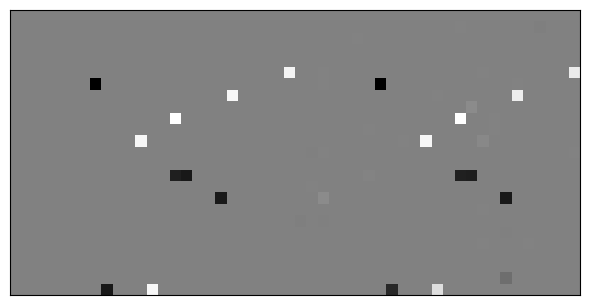

tensor([ 0.0000e+00, -0.0000e+00,  0.0000e+00,  ...,  9.4831e-05,
         1.6251e-04, -1.3397e-04], grad_fn=<CatBackward0>)

In [237]:
# Plot the figure
plt.figure(figsize=(6, 4))
yz = torch.cat([y, z])
print(yz.shape)
plt.imshow(yz.detach().view(2*w_s, h_s).T, cmap=plt.cm.gray_r)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()
yz

In [260]:

hopfield_model = HopfieldNetworkTorch(T)

def forward_ca3_memory_model(hopfield_model, pp):
    u = hopfield_model(pp)
    return u

def train_ca3_memory_model(hopfield_model, y, z):
    # ca3_input = torch.cat([y, z]).clone().detach()
    # for i in range(5):
    hopfield_model.store_pattern(z)
    # hopfield_model.store_patterns(torch.stack([y, y, y, y]))
    u = forward_ca3_memory_model(hopfield_model, z)
    return u


In [239]:
z = torch.clamp(z * 10.0, min=-1.0, max=1.0)
for i in range (2):
    u = train_ca3_memory_model(hopfield_model, y, z)

zz = torch.clamp(zz * 10.0, min=-1.0, max=1.0)
for i in range (2):
    uu = train_ca3_memory_model(hopfield_model, yy, zz)

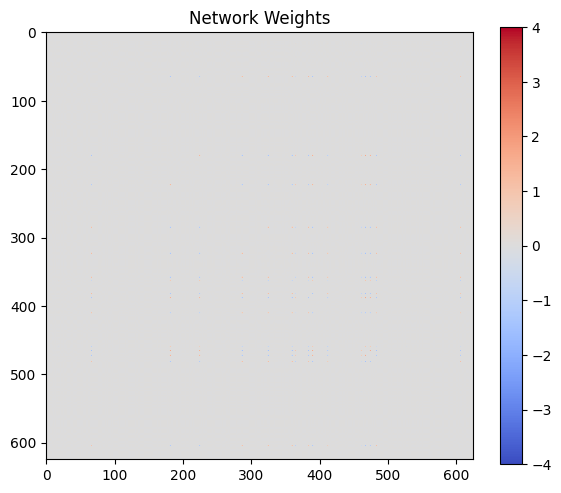

In [240]:
hopfield_model.plot_weights()

In [241]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, h, d_model, d_context, d_output):
        super(Attention, self).__init__()
        self.h = h
        self.d_k = d_model // h
        self.d_v = d_context
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_output)

    def forward(self, z):
        if len(z.shape) == 1:
            batch_size = 1
        else:
            batch_size = z.shape[0]
        
        zz = z.view(batch_size, self.d_k)
        q = zz[:, :]
        k = zz[:, :]
        v = zz[:, :]
        
        query = self.q_linear(q)
        key = self.k_linear(k)
        value = self.v_linear(v)
        
        key_t = key.transpose(-2, -1)
        scores = torch.matmul(query, key_t) / math.sqrt(self.d_k)
        for x in range(self.d_v):
            for y in range(self.d_v):
                if y < x:
                    scores[:, x, y] = torch.zeros((batch_size))
                    
        p_attn = F.softmax(scores, dim=-1)

        x = torch.matmul(p_attn, value)

        x = self.out_linear(x)
        x = torch.sum(x, 1)
        return x

### Visualization

This is what is really stored in memory. Trying to grasp what kind of transformation happens in these three networks.

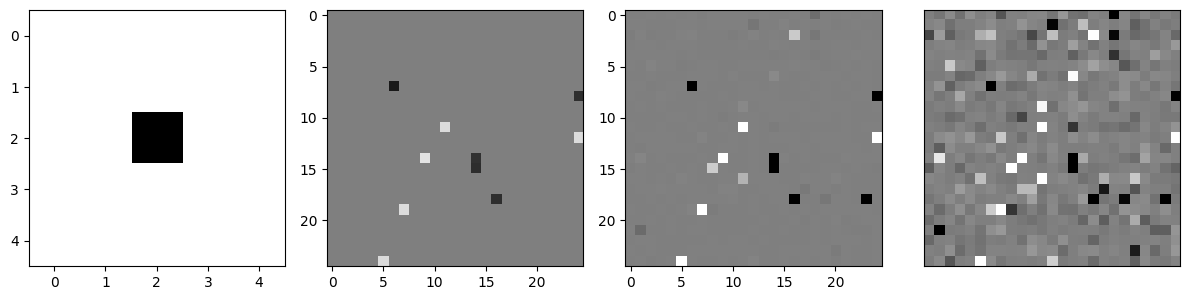

In [242]:
cmap = plt.cm.gray
norm = plt.Normalize(vmin=-1, vmax=1)

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)


# Plot the figure
#plt.figure(figsize=(6, 4))
#plt.imshow(x, cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

## Mapping and reconstruction

This is the last block that is mainly used for retrieval.  

In [243]:
class MappingModel(nn.Module):
    """
    Goal: pattern mapping
    Methods: compare what stored in memory with the original
    """
    
    def __init__(self, input_size, hidden_size, output_size):
        super(MappingModel, self).__init__()
        
        # Layers for mapping and reconstruction
        self.fc_map = nn.Linear(input_size, hidden_size)  # Map Hopfield output to hidden representation
        self.fc_reconstruct = nn.Linear(hidden_size, output_size)  # Reconstruct to original size

    def forward(self, x):
        """
        Forward pass compares stored Hopfield output with the original input
        """
        # Map the Hopfield output to a hidden representation
        mapping = self.fc_map(x)
        hidden_repr = torch.tanh(mapping)
        reconstructed_input = self.fc_reconstruct(hidden_repr)
        return reconstructed_input

In [244]:

# Instantiate the model
ca1_model = MappingModel(input_size, hidden_size, output_size)

# Define optimizer (e.g., Adam)
ca1_optimizer = optim.Adam(ca1_model.parameters(), lr=0.0001)

ca1_criterion = nn.MSELoss() # good for comparing pixel values

def forward_ca1_model(ca1_model, u, x):
    ca1_input = torch.cat([u, x]) # u -> K, x -> N
    # Compare reconstruction with the original input
    v = ca1_model(ca1_input)
    return v
    
def train_ca1_model(ca1_model, u, x, a):
    # Zero the parameter gradients
    ca1_optimizer.zero_grad()

    v = forward_ca1_model(ca1_model, u, x)
    loss = ca1_criterion(v, a)

    # Backward pass: compute gradients
    loss.backward()

    # Optimization step: update weights
    ca1_optimizer.step()

    print("Loss:", loss.item())
    print("Reconstructed Input:", v)
    
    return v

Loss: 0.9895539283752441
Reconstructed Input: tensor([-0.0082,  0.0045,  0.0628, -0.0285, -0.1054,  0.0871, -0.0523, -0.0665,
        -0.2271,  0.0032,  0.0520,  0.0024,  0.0015,  0.1327, -0.0331, -0.0279,
        -0.0340,  0.0340,  0.0029, -0.0355,  0.1696,  0.0247, -0.0204,  0.0849,
         0.0994], grad_fn=<AddBackward0>)
Loss: 0.9419647455215454
Reconstructed Input: tensor([-0.0323, -0.0159,  0.0843, -0.0565, -0.1253,  0.0589, -0.0795, -0.0348,
        -0.2479, -0.0227,  0.0753,  0.0247,  0.0349,  0.1543, -0.0104, -0.0541,
        -0.0525,  0.0488, -0.0245, -0.0527,  0.1408,  0.0003,  0.0080,  0.0578,
         0.0796], grad_fn=<AddBackward0>)
Loss: 0.895551323890686
Reconstructed Input: tensor([-0.0564, -0.0365,  0.1058, -0.0842, -0.1453,  0.0307, -0.1070, -0.0033,
        -0.2689, -0.0487,  0.0986,  0.0469,  0.0683,  0.1757,  0.0122, -0.0805,
        -0.0710,  0.0640, -0.0517, -0.0699,  0.1123, -0.0242,  0.0365,  0.0309,
         0.0593], grad_fn=<AddBackward0>)
Loss: 0.850275278

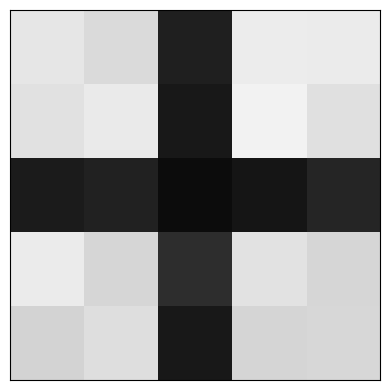

In [245]:
a = output_1.flatten()
aa = output_2.flatten()

for i in range(30):
    v = train_ca1_model(ca1_model, u, x, a)


# Plot the figure
plt.figure(figsize=(6, 4))
plt.imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

In [246]:

# x = input_2.flatten()
# a = output_2.flatten()

# y = forward_dg_model(dg_model, x)
# z, _ = train_ec_to_ca3_model(ec_model, x, y)
# u = train_ca3_memory_model(hopfield_model, y, z)
# v = train_ca1_model(ca1_model, u, x, a)


In [247]:
# fig, axs = plt.subplots(1, 5, figsize=(12, 4))
# axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
# axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
# axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
# axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
# axs[4].imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)

# plt.xticks([])  # No ticks on x axis
# plt.yticks([])  # No ticks on y axis
# plt.tight_layout()
# plt.grid(False)
# plt.show()

Loss: 1.259421706199646
Reconstructed Input: tensor([-0.4272, -0.3009,  0.4430, -0.4204, -0.5783, -0.3874, -0.5320,  0.4472,
        -0.4741, -0.4648,  0.3237,  0.3775,  0.5728,  0.3720,  0.4093, -0.3815,
        -0.4061,  0.3628, -0.3922, -0.3079, -0.3571, -0.3084,  0.4687, -0.3569,
        -0.3945], grad_fn=<AddBackward0>)
Loss: 1.2599139213562012
Reconstructed Input: tensor([-0.4419, -0.3173,  0.4492, -0.4349, -0.5793, -0.4033, -0.5448,  0.4509,
        -0.4880, -0.4688,  0.3281,  0.3832,  0.5742,  0.3774,  0.4257, -0.3962,
        -0.4213,  0.3690, -0.4083, -0.3141, -0.3643, -0.3143,  0.4829, -0.3656,
        -0.4018], grad_fn=<AddBackward0>)
Loss: 1.2510566711425781
Reconstructed Input: tensor([-0.4564, -0.3345,  0.4504, -0.4495, -0.5727, -0.4194, -0.5575,  0.4477,
        -0.5028, -0.4663,  0.3259,  0.3831,  0.5685,  0.3777,  0.4432, -0.4111,
        -0.4363,  0.3698, -0.4255, -0.3146, -0.3658, -0.3143,  0.4971, -0.3702,
        -0.4038], grad_fn=<AddBackward0>)
Loss: 1.235101819

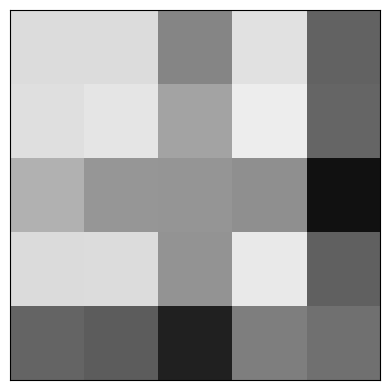

In [248]:
# Another step
for i in range(30):
    vv = train_ca1_model(ca1_model, uu, xx, aa)


plt.figure(figsize=(6, 4))
plt.imshow(vv.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

TypeError: view() received an invalid combination of arguments - got (Tensor, int), but expected one of:
 * (torch.dtype dtype)
 * (tuple of ints size)


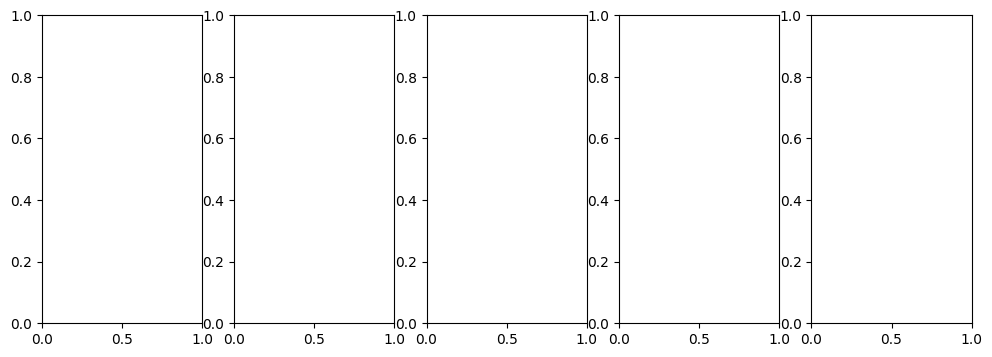

In [294]:

x = input_1.flatten()
a = output_1.flatten()

with torch.no_grad():
    y = forward_dg_model(dg_model, x)
    z = forward_ec_to_ca3_model(ec_model, x)
    u = forward_ca3_memory_model(hopfield_model, z)
    v = forward_ca1_model(ca1_model, u, x)

    fig, axs = plt.subplots(1, 5, figsize=(12, 4))
    axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
    axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[4].imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)

plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

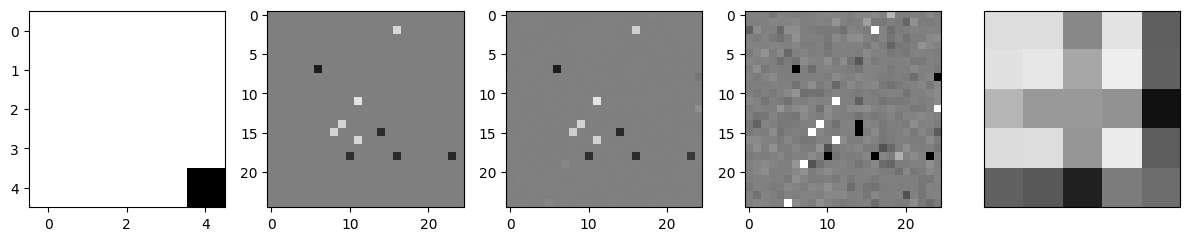

In [250]:
x = input_2.flatten()
a = output_2.flatten()

with torch.no_grad():
    y = forward_dg_model(dg_model, x)
    z = forward_ec_to_ca3_model(ec_model, x)
    u = forward_ca3_memory_model(hopfield_model, z)
    v = forward_ca1_model(ca1_model, u, x)

    fig, axs = plt.subplots(1, 5, figsize=(12, 4))
    axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
    axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[4].imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)

plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

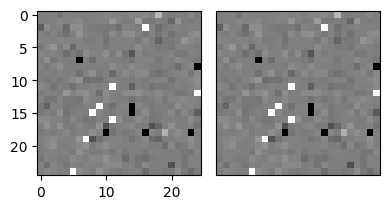

In [251]:

with torch.no_grad():
    x1 = input_1.flatten()
    a1 = output_1.flatten()

    y1 = forward_dg_model(dg_model, x1)
    z1 = forward_ec_to_ca3_model(ec_model, x1)
    u1 = forward_ca3_memory_model(hopfield_model, z1)

    x2 = input_2.flatten()
    a2 = output_2.flatten()

    y2 = forward_dg_model(dg_model, x2)
    z2 = forward_ec_to_ca3_model(ec_model, x2)
    u2 = forward_ca3_memory_model(hopfield_model, z2)


    fig, axs = plt.subplots(1, 2, figsize=(4, 4))
    axs[0].imshow(u1.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[1].imshow(u2.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)


plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

C:\Users\neupo\AppData\Local\Temp\ipykernel_15924\3567843866.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y1_vs_y2 = torch.tensor((y1+1.0)/2.0 - (y2+1.0)/2.0)


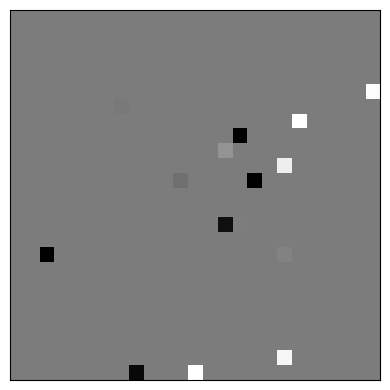

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.3422,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

In [259]:
# Plot the figure
plt.figure(figsize=(6, 4))
y1_vs_y2 = torch.tensor((y1+1.0)/2.0 - (y2+1.0)/2.0)
plt.imshow(y1_vs_y2.detach().view(w_s, h_s).T, cmap=plt.cm.gray_r)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()
y1_vs_y2

In [253]:
# ( 1 ) * (1 0) = [ 1 0
#   0               0 0 ]
# a = torch.tensor([1,-1]).unsqueeze(1)
# # tensor([[ 1, -1],
#         #[-1,  1]])
# w1 = torch.mm(a, a.T)

In [254]:
# b = torch.tensor([1,1]).unsqueeze(1)
# w2 = torch.mm(b, b.T)
# tensor([[ 1, -1],
        #[-1,  1]])

In [255]:
# torch.tanh(torch.mm(w1+w2, a))

In [256]:
hopfield_model.weights

tensor([[ 0.0000e+00,  1.7435e-06, -1.7009e-06,  ...,  2.2959e-07,
         -1.1402e-07, -1.0214e-06],
        [ 1.7435e-06,  0.0000e+00, -3.3436e-05,  ...,  3.2682e-07,
         -1.6643e-05, -2.4094e-05],
        [-1.7009e-06, -3.3436e-05,  0.0000e+00,  ..., -1.8484e-06,
          1.0293e-05,  2.1103e-05],
        ...,
        [ 2.2959e-07,  3.2682e-07, -1.8484e-06,  ...,  0.0000e+00,
          9.6491e-06,  1.6140e-06],
        [-1.1402e-07, -1.6643e-05,  1.0293e-05,  ...,  9.6491e-06,
          0.0000e+00,  1.6766e-05],
        [-1.0214e-06, -2.4094e-05,  2.1103e-05,  ...,  1.6140e-06,
          1.6766e-05,  0.0000e+00]], grad_fn=<CopySlices>)

In [257]:
t, _ = torch.topk(torch.tanh(torch.mm(hopfield_model.weights, z1.unsqueeze(1))).flatten(), 15)
t

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.4336, 0.2704,
        0.2649, 0.2390, 0.2201, 0.2105, 0.2041, 0.1757],
       grad_fn=<TopkBackward0>)

In [266]:
w = torch.zeros(w_s, h_s)

In [268]:
w = torch.mm(z.unsqueeze(1), z.unsqueeze(1).T)

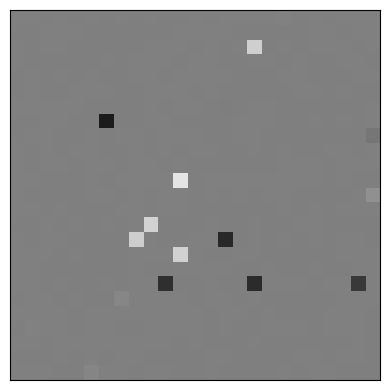

In [296]:
s = torch.rand(625).unsqueeze(1)
for i in range(1):
    s = torch.mm(w, s)

plt.figure(figsize=(6, 4))
plt.imshow(z2.view(w_s, h_s).detach(), cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

In [265]:
w_s * h_s

625